In [249]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
sns.set_style('whitegrid')


### Data imports

In [173]:
df = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
df.head(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Feature analysis
The age is missing a significant amount of values but we want to use it in the model, we will use Sibsp to estimate the age.\

Cabin is missing too many values to be useful,\
Name is a label atrribute. making these two columns expendable.


In [175]:
df = df.drop(['Cabin','Name'], axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


### A significant amount of Age entries are missing. However age could be useful as children and the elderly would be priortized we will be using the PSibSp categorical feature to estimate missing age entries

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

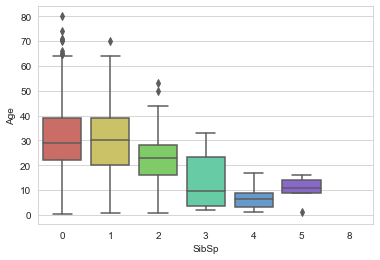

In [176]:
sns.boxplot(x='SibSp', y ='Age',data=df,palette='hls')

In [177]:
Sibsp_groups = df.groupby(df['SibSp'])
Sibsp_groups.mean()

,PassengerId,Survived,Pclass,Age,Parch,Fare
SibSp,,,,,,
0,455.370066,0.345395,2.351974,31.397558,0.185855,25.692028
1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


In [178]:
df.Age.mean()

29.69911764705882

In [179]:
def age_approx_Sibsp(cols):
    '''
    Approximates the age of a passenger based on the number 
    of siblings/spouse onboard if passenger's age is not provided

    -----------------------------
    Parameters (columns):
    Age and sibsp columns

    ----------------------------
    Returns (int):
    Age of passengers
    '''
    Age =cols[0]
    sibsp=cols[1]
    
    if pd.isnull(Age):
        if sibsp == 0:
            return 31
        elif sibsp ==1:
            return 30
        elif sibsp ==2:
            return 23
        elif sibsp ==3:
            return 13
        else:
            return 29
        
    else:
        return Age
            

In [180]:
df['Age'] = df[['Age','SibSp']].apply(age_approx_Sibsp,axis = 1)

In [181]:
df = df.dropna()
#df.info()

### Converting gender to a binary feature

In [182]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = df['Sex']
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]
# 0 - female, 1 - male

array([1, 0, 0, 0, 1])

In [183]:
gender_cat_y = test_data['Sex']
gender_encoded_y = label_encoder.fit_transform(gender_cat_y)
gender_encoded_y[0:5]

array([1, 0, 1, 1, 0])

In [184]:
gender_Df = pd.DataFrame(gender_encoded,columns=['male_gender'])

### Converting embarked to a binary feature

In [185]:
#
embarked_cat = df['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
embarked_encoded[0:10]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0])

In [186]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_binary = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_binary = embarked_binary.toarray()
locations = ['C','Q','S']
embarked_binary_DF = pd.DataFrame(embarked_binary, columns = locations)
embarked_binary_DF

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
884,0.0,0.0,1.0
885,0.0,0.0,1.0
886,0.0,0.0,1.0
887,1.0,0.0,0.0


In [187]:
# Intergrate the binary features with the original data
titanic = pd.concat([df,gender_Df,embarked_binary_DF],axis=1,verify_integrity=True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Survived     889 non-null    float64
 2   Pclass       889 non-null    float64
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    float64
 6   Parch        889 non-null    float64
 7   Ticket       889 non-null    object 
 8   Fare         889 non-null    float64
 9   Embarked     889 non-null    object 
 10  male_gender  889 non-null    float64
 11  C            889 non-null    float64
 12  Q            889 non-null    float64
 13  S            889 non-null    float64
dtypes: float64(11), object(3)
memory usage: 104.4+ KB


### Feature Design

<AxesSubplot:>

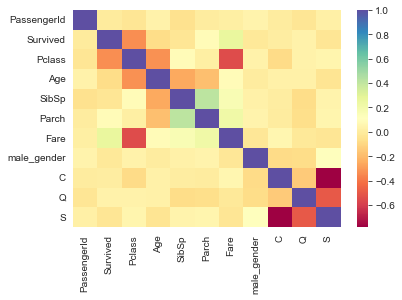

In [188]:
#Linear regression assumes predictors are independent of each so we want to drop all dependent features

sns.heatmap(titanic.corr(),cmap=sns.color_palette('Spectral',as_cmap=True))
# Pclass and Fare have a high correlation

In [189]:
# drop all label features of the dataset and the features that have been converted to binary form
titanic = titanic.drop(['Pclass','Sex','Embarked','Ticket'],axis=1)
titanic.head(5)

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


In [190]:
titanic.isnull().sum()

PassengerId    2
Survived       2
Age            2
SibSp          2
Parch          2
Fare           2
male_gender    2
C              2
Q              2
S              2
dtype: int64

In [191]:
titanic = titanic.dropna()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 888
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  887 non-null    float64
 1   Survived     887 non-null    float64
 2   Age          887 non-null    float64
 3   SibSp        887 non-null    float64
 4   Parch        887 non-null    float64
 5   Fare         887 non-null    float64
 6   male_gender  887 non-null    float64
 7   C            887 non-null    float64
 8   Q            887 non-null    float64
 9   S            887 non-null    float64
dtypes: float64(10)
memory usage: 76.2 KB


In [192]:
features = ['PassengerId','Fare','SibSp','Parch','Age','male_gender','C','Q','S']

In [193]:
X_train,X_test, y_train,y_test = train_test_split(titanic[features],titanic['Survived'], 
                                                  test_size = 0.2)


In [194]:
#scale training data
X_train,X_test = scale(X_train),scale(X_test)

### Conversion of multiclass and variable featurs of test.csv to binary classifies

In [195]:
test_data['Age'] = test_data[['Age','Parch']].apply(age_approx_Sibsp,axis = 1)

In [196]:
gender_Df_y = pd.DataFrame(gender_encoded_y,columns=['male_gender'])


embarked_cat_y = test_data['Embarked']
embarked_encoded_y = label_encoder.fit_transform(embarked_cat_y)
print(embarked_encoded_y[0:10])


embarked_binary_y = binary_encoder.fit_transform(embarked_encoded_y.reshape(-1,1))
embarked_binary_y = embarked_binary_y.toarray()
locations = ['C','Q','S']
embarked_binary_DF_y = pd.DataFrame(embarked_binary_y, columns = locations)
embarked_binary_DF_y

[1 2 1 2 2 2 1 2 0 2]


,C,Q,S
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
413,0.0,0.0,1.0
414,1.0,0.0,0.0
415,0.0,0.0,1.0
416,0.0,0.0,1.0


In [197]:
titanic_test = pd.concat([test_data,gender_Df_y,embarked_binary_DF_y],axis=1,verify_integrity=True)


titanic_test = titanic_test.drop(['Name','Pclass','Sex','Embarked','Ticket','Cabin'],axis=1)
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   SibSp        418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Fare         417 non-null    float64
 5   male_gender  418 non-null    int32  
 6   C            418 non-null    float64
 7   Q            418 non-null    float64
 8   S            418 non-null    float64
dtypes: float64(5), int32(1), int64(3)
memory usage: 27.9 KB


In [198]:
titanic_test = titanic_test.dropna()
#titanic_test.info()

In [199]:
#titanic_test.isnull().sum()

## Model implementation

### LOGISTIC_REGRESSION

In [200]:

#Logistic Regressor Model
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train,y_train)

logreg_train =LogReg.predict(X_train)
logreg_test = LogReg.predict(X_test)

In [201]:
print('Classification Report: LOGISTIC REGRESSION')
print('Training Score')
print(classification_report(y_train,logreg_train))
print('Testing Score')
print(classification_report(y_test,logreg_test))

Classification Report: LOGISTIC REGRESSION
Training Score
              precision    recall  f1-score   support

         0.0       0.66      0.95      0.78       437
         1.0       0.72      0.22      0.33       272

    accuracy                           0.67       709
   macro avg       0.69      0.58      0.56       709
weighted avg       0.68      0.67      0.61       709

Testing Score
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83       111
         1.0       0.92      0.36      0.52        67

    accuracy                           0.75       178
   macro avg       0.82      0.67      0.67       178
weighted avg       0.79      0.75      0.71       178



In [202]:
logreg_train_crossval = cross_val_predict(LogReg,X_train,y_train,cv=5)
#confusion_matrix(y_train,logreg_train_cross)

In [203]:
logreg_test_crossval = cross_val_predict(LogReg,X_test,y_test,cv=5)
#confusion_matrix(y_test,logreg_test_crossval)

### KNeighbors

In [204]:
# KNeighbors
# for k in [5,8,9,10,15,20]:
#     knc = neighbors.KNeighborsClassifier(n_neighbors = k)
#     knc.fit(X_train,y_train)
#     knc_train = knc.predict(X_train)
#     knc_test = knc.predict(X_test)
#     knc_tst_score = knc.score(X_test,y_test)
#     print(f'for {k} neighbours the test score is {knc_tst_score}')
# #optimal k = 8

In [205]:
knc = neighbors.KNeighborsClassifier(n_neighbors = 8)
knc.fit(X_train,y_train)
knc_train = knc.predict(X_train)
knc_test = knc.predict(X_test)
knc_tst_score = knc.score(X_test,y_test)

In [206]:
print('Classification Report: KNeighbors(K=8)')
print('Training Score')
print(classification_report(y_train,knc_train))
print('Testing Score')
print(classification_report(y_test,knc_test))

Classification Report: KNeighbors(K=8)
Training Score
              precision    recall  f1-score   support

         0.0       0.72      0.94      0.82       437
         1.0       0.81      0.43      0.56       272

    accuracy                           0.74       709
   macro avg       0.76      0.68      0.69       709
weighted avg       0.76      0.74      0.72       709

Testing Score
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83       111
         1.0       0.88      0.42      0.57        67

    accuracy                           0.76       178
   macro avg       0.80      0.69      0.70       178
weighted avg       0.79      0.76      0.73       178



In [207]:
y_train_pred = cross_val_predict(knc,X_train,y_train,cv=5)
#confusion_matrix(y_train,y_train_pred)

In [208]:
y_test_mat = cross_val_predict(knc,X_test,y_test,cv=5)
#confusion_matrix(y_test,y_test_mat)

### Random Forest

In [262]:

rf = RandomForestClassifier(n_estimators = 400, criterion='gini') 
rf.fit(X_train,y_train) 
f_train = rf.predict(X_train)
f_test = rf.predict(X_test)

In [258]:
print('Classification Report: Random Forest Tree')
print('Training Score')
print(classification_report(y_train,rf_train))
print('Testing Score')
print(classification_report(y_test,rf_test))

Classification Report: KNeighbors(K=8)
Training Score
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       437
         1.0       1.00      1.00      1.00       272

    accuracy                           1.00       709
   macro avg       1.00      1.00      1.00       709
weighted avg       1.00      1.00      1.00       709

Testing Score
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.83       111
         1.0       0.74      0.63      0.68        67

    accuracy                           0.78       178
   macro avg       0.77      0.75      0.75       178
weighted avg       0.77      0.78      0.77       178



### Kaggle Submission

In [226]:
submission = pd.DataFrame(list())
submission.to_csv('submission.csv')
submission['Passenger_Id'] = titanic_test.PassengerId
submission.set_index('Passenger_Id')
submission

,Passenger_Id
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [245]:
kaggle_sub = knc.predict(titanic_test)

In [246]:
submission = titanic_test.copy()

In [247]:

submission = submission.drop(['Age','SibSp','Parch','Fare','male_gender','C','Q','S'],axis=1)
submission.set_index('PassengerId')


""
PassengerId
892
893
894
895
896
...
1305
1306
1307


In [248]:
submission['prediction'] = kaggle_sub
submission

,PassengerId,prediction
0,892,1.0
1,893,1.0
2,894,1.0
3,895,0.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


,Age,SibSp,Parch,Fare,male_gender,C,Q,S,prediction
PassengerId,,,,,,,,,
892,34.5,0,0,7.8292,1,0.0,1.0,0.0,1.0
893,47.0,1,0,7.0000,0,0.0,0.0,1.0,1.0
894,62.0,0,0,9.6875,1,0.0,1.0,0.0,1.0
895,27.0,0,0,8.6625,1,0.0,0.0,1.0,0.0
896,22.0,1,1,12.2875,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1305,31.0,0,0,8.0500,1,0.0,0.0,1.0,0.0
1306,39.0,0,0,108.9000,0,1.0,0.0,0.0,1.0
1307,38.5,0,0,7.2500,1,0.0,0.0,1.0,0.0


0.7921348314606742